In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as st
import warnings
warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv('wide.csv')
df_1 = df[['ln_estim', 'ln_res_i', 'ln_max_bid', 'result']]
df_1.dropna(inplace=True)
df_1['M-E'] = pd.Series(df_1['ln_max_bid'] - df_1['ln_estim'], index=df_1.index)
df_1['R-E'] = pd.Series(df_1['ln_res_i'] - df_1['ln_estim'], index=df_1.index)

<AxesSubplot:xlabel='R-E', ylabel='M-E'>

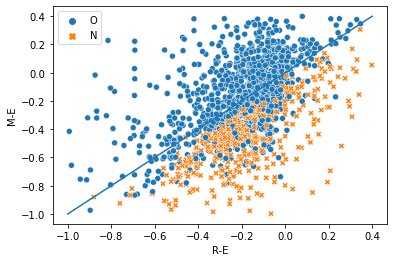

In [3]:
df_1 = df_1[(df_1['M-E'] > -1) & (df_1['M-E'] < 0.4)]
df_1 = df_1[(df_1['R-E'] > -1) & (df_1['R-E'] < 0.4)]

sns.scatterplot(data=df_1,
                x="R-E",
                y="M-E",
                hue="result",
                style="result")
sns.lineplot(x=np.linspace(-1,0.4),
             y=np.linspace(-1,0.4))

We can find several observations "O" under the blue line, but there are no orange crosses (not-sold lots) above it. So, we can conclude that a certain rule is used here: if max bid is higher than the reserved price lot still can be sold with less revenue, however max bid of every not-sold lot was less than the reserved price. 

In [4]:
df = df[df['n_bidders'] > 1]
#df = df[df['max_bid'] < df['res_i']]
df['mean_bid'] = (df['mean_bid'] * df['n_bidders'] - df['max_bid']) / (df['n_bidders'] - 1)
df_2 = df[['owner', 'max_bid', 'mean_bid', 'estim', 'result', 'res_i']]

In [5]:
df_2['ln_n_bidders'] = np.log(df['n_bidders']+1)

In [6]:
df_2['owner'].replace({'AS': 0,
                     'DO': 1}, inplace=True)
df_2['result'].replace({'N': 0,
                      'O': 1}, inplace=True)
df_2.describe()

,owner,max_bid,mean_bid,estim,result,res_i,ln_n_bidders
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000
mean,0.314240,13469.634049,10423.482870,15905.180589,0.777247,13609.536993,1.532764
std,0.464397,11960.021903,8941.262546,13964.027823,0.416259,11952.419254,0.387990
min,0.000000,183.000000,152.000000,441.000000,0.000000,200.000000,1.098612
25%,0.000000,5700.000000,4459.000000,6543.000000,1.000000,5500.000000,1.098612
50%,0.000000,10080.000000,7936.000000,11785.000000,1.000000,10000.000000,1.386294
75%,1.000000,17500.000000,13336.500000,20916.000000,1.000000,18000.000000,1.791759
max,1.000000,140750.000000,88716.857143,131662.000000,1.000000,112000.000000,2.639057


In [7]:
y = df_2.result
X = df_2.drop(['result', 'res_i'], axis=1)
X['max_bid'] = X['max_bid'] / df['res_i']
X['mean_bid'] = X['mean_bid'] / df['res_i']
X['estim'] = X['estim'] / df['res_i']
X['owner*ln_n_bidders'] = X['owner'] * X['ln_n_bidders']
X['owner*max_bid'] = X['owner'] * X['max_bid']
X['owner*mean_bid'] = X['owner'] * X['mean_bid']
X['owner*estim'] = X['owner'] * X['estim']
X['const'] = 1

In [8]:
X.describe()

,owner,max_bid,mean_bid,estim,ln_n_bidders,owner*ln_n_bidders,owner*max_bid,owner*mean_bid,owner*estim,const
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.0
mean,0.314240,1.043665,0.810151,1.200995,1.532764,0.502377,0.344700,0.265735,0.389577,1.0
std,0.464397,0.378445,0.283654,0.300218,0.387990,0.777368,0.577952,0.431223,0.600362,0.0
min,0.000000,0.379412,0.200000,0.189459,1.098612,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.852667,0.658333,1.067500,1.098612,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,0.974619,0.785733,1.155571,1.386294,0.000000,0.000000,0.000000,0.000000,1.0
75%,1.000000,1.158571,0.916571,1.283600,1.791759,1.098612,0.846471,0.644172,1.068545,1.0
max,1.000000,7.458000,4.795000,4.454889,2.639057,2.639057,7.458000,3.157250,4.049500,1.0


In [9]:
logit_model = st.Logit(y,X)
res_1 = logit_model.fit()
print(res_1.summary2())

Optimization terminated successfully.
         Current function value: 0.314387
         Iterations 9
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.407      
Dependent Variable:  result            AIC:               810.3687   
Date:                2022-09-19 12:55  BIC:               861.7335   
No. Observations:    1257              Log-Likelihood:    -395.18    
Df Model:            9                 LL-Null:           -666.67    
Df Residuals:        1247              LLR p-value:       3.5587e-111
Converged:           1.0000            Scale:             1.0000     
No. Iterations:      9.0000                                          
---------------------------------------------------------------------
                    Coef.   Std.Err.    z     P>|z|   [0.025   0.975]
---------------------------------------------------------------------
owner                7.0331   2.0672   3.4023 0.0007   2.9816 11.0847
max_bid         

#### Adding control variables

In [10]:
cat_cols = ['stand', 'cut', 'grape', 'land_area', 'quality', 'conditions']

In [11]:
X = X.join(pd.get_dummies(df[cat_cols]))

In [12]:
logit_model = st.Logit(y,X)
res_2 = logit_model.fit()
print(res_2.summary2())

Optimization terminated successfully.
         Current function value: 0.291900
         Iterations 12
                                   Results: Logit
Model:                    Logit                  Pseudo R-squared:       0.450      
Dependent Variable:       result                 AIC:                    799.8368   
Date:                     2022-09-19 12:55       BIC:                    969.3407   
No. Observations:         1257                   Log-Likelihood:         -366.92    
Df Model:                 32                     LL-Null:                -666.67    
Df Residuals:             1224                   LLR p-value:            7.4932e-106
Converged:                1.0000                 Scale:                  1.0000     
No. Iterations:           12.0000                                                   
------------------------------------------------------------------------------------
                    Coef.     Std.Err.      z    P>|z|      [0.025         0.975] 

In [13]:
num_cols = ['surf', 'ln_n_trees', 'v_crown',
            'v_stem', 'v_stump', 'v_stem_other_foliar',
            'v_stem_other_conifer', 'v_stem_oak', 'v_stem_spruce',
            'v_stem_beech', 'v_stem_pine', 'v_stem_fir', 'v_crown_foliar',
            'v_crown_conifer', 'lot_order', 'herf1']

X = X.join(df[num_cols])

In [14]:
logit_model = st.Logit(y,X)
res_3 = logit_model.fit()
print(res_3.summary2())

         Current function value: 0.283244
         Iterations: 35
                                       Results: Logit
Model:                       Logit                     Pseudo R-squared:          0.466      
Dependent Variable:          result                    AIC:                       810.0765   
Date:                        2022-09-19 12:55          BIC:                       1061.7642  
No. Observations:            1257                      Log-Likelihood:            -356.04    
Df Model:                    48                        LL-Null:                   -666.67    
Df Residuals:                1208                      LLR p-value:               1.0835e-100
Converged:                   0.0000                    Scale:                     1.0000     
No. Iterations:              35.0000                                                         
---------------------------------------------------------------------------------------------
                         Coef.    

The logit models show the importance of the features "owner", "highest bid", "mean bid", "ln_n_bidders". Feature "estim" (appraisal value) become unimportant on every rational important level after adding control variables, so this can be the signal of the wrong specification of the model (or some other econometrician problems). Pseudo R-sq is raising which is an common thing with adding more variables to the model, so we cannot make conclusion with its help.

### The main idea of the paper:

In many auctions bidders are more informed about heterogeneity of the good than the seller. So the second should use different instruments to operate more efficiently. This is achieved by two methods described in the article: <br />
1) Keeping the reserved price in secret <br />
2) Learn more about heterogeneity with the help of incoming bids <br />
<br />
The second option provides the seller with the information about "market value" of the item, so they can change their reserved price to gain more revenue (less profit than with initial appraisal value, but with greater chances to sell the good). However, this technique will work efficiently only with the first condition. Secret reserve price make bidders behave more "realistic" and do not change their prices based on the information about the reserve price. <br />
<br />
The French timber industry provides good data to be analysed as sellers used suggested methods and there is an assymetric information between bidders and seller. Analysing this dataset gave counterfactual results: <br />
*Using the information conveyed by bids allows the seller to improve allocative efficiency. However, learning from the bids induces less aggressive bidding and lower revenue by relaxing the seller’s commitment power* - quote from the paper. (I think perephrasing two sentences does not make sense about my whole understanding of the paper and these two sentences are ideal and convey the idea very accurately, so perephrasing them is just the waste of time) :))
